In [18]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model, to_categorical
# from tensorflow.keras.preprocessing import 
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [19]:
pwd = os.getcwd()
database_path = pwd[:-6] + "flightData/filtered_data/scenario5"

In [20]:
database_file_names = []
for root, dirs, files in os.walk(database_path):
    database_file_names = [os.path.join(root,file) for file in files]
#     print(database_file_names)

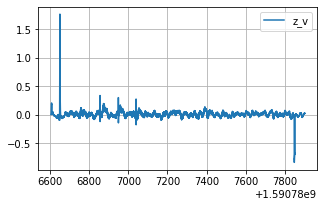

In [21]:
plt.figure(figsize=(5,3))
# for i,file in enumerate(database_file_names):
file = database_file_names[0]
data = pd.read_csv(file)
# i=1
col = data.columns[13]
# for col in data.columns:
#     if col=='time':
#         continue
x = data['time'].values
y = data[col].values
#     plt.subplot(7,2,i)
plt.plot(x,y,label=col)
plt.grid()
plt.legend()
#     i=i+1
    #     data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    #     data.to_csv(file,index=False)
#     old_label = pd.unique(data['label'])
#     print(old_label)
#     new_label = [j for j in range(1,len(old_label)+1)]
#     data = data.replace(old_label, new_label)
#     #     print(file)
#     x = data['x'].values
#     y = data['y'].values
#     t = data['time'].values
#     label = data['label'].values
# #     label[22800:25350] = 4
#     label = label*10
#     plt.subplot(25,2,i+1)
#     #     plt.plot(t,x)
#     indx = 0
#     plt.plot(y[indx:])
#     plt.plot(label[indx:])
#     plt.grid()
#     file_name = file.split("/")
#     file_name = file_name[-1]
#     plt.title(file_name)

# newfile = file[:-4]+'_new.csv'
# data = data.replace(new_label, old_label)
# data.to_csv(newfile, index=False)

#     print(i)

In [22]:
data.head()

,label,pitch,pitch_v,roll,roll_v,time,x,x_v,y,y_v,yaw,yaw_v,z,z_v
0,Hold,-0.0,0.0,0.0,0.0,1.590787e+09,-0.000006,-0.000833,-0.000001,-0.000181,0.0,0.0,0.000001,0.000533
1,Hold,-0.0,0.0,0.0,0.0,1.590787e+09,-0.000006,-0.000833,-0.000001,-0.000181,0.0,0.0,0.000001,0.000533
2,Hold,-0.0,0.0,0.0,0.0,1.590787e+09,-0.000032,-0.000287,-0.000026,-0.000763,0.0,0.0,0.000070,0.005525
3,Hold,-0.0,0.0,0.0,0.0,1.590787e+09,-0.000032,-0.000287,-0.000026,-0.000763,0.0,0.0,0.000070,0.005525
4,Hold,-0.0,0.0,0.0,0.0,1.590787e+09,-0.000005,0.001337,-0.000038,-0.000442,0.0,0.0,-0.000058,0.010803


In [23]:
print([i for i in range(1,len(pd.unique(data['label']))+1)])

[1, 2, 3, 4, 5, 6, 7]


In [24]:
print(pd.unique(data['label']))

['Hold' 'Takeoff' 'Hover' 'Search' 'Obstacleavoid' 'Loiter' 'Land']


In [25]:
print(file[:-4]+'_new.csv')

/home/ariac/ros-intel-uav-rpeo/simulation_ws/src/pie/flightData/filtered_data/scenario5/scenario5_1_new_new.csv


In [26]:
X_train = data.drop(columns=['label', 'time'])
X_train = X_train.values
print(X_train.shape)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
Y_train = data['label'].values
Y_train = Y_train.reshape((-1,1))
encoder = OneHotEncoder()
Y_train = encoder.fit_transform(Y_train).toarray()
print(Y_train.shape)
print(Y_train[0,:])

(77305, 12)
(77305, 7)
[1. 0. 0. 0. 0. 0. 0.]


In [27]:
def batch_gen(X,y,time_step,batch_size=64):
    i = 0
    m = X.shape[0]
    while True:
        x_batch = []
        y_batch = []
        for j in range(batch_size):
            if i+j+time_step == m:
                i = -1
                break
            x_batch.append(X[i+j:i+j+time_step,:])
            y_batch.append(y[i+j+time_step,:])
        yield (np.array(x_batch), np.array(y_batch), i)
        i = i+1
        


In [28]:
# X = [[1,6],[2,7],[3,8],[4,9],[5,10]]
# Y = [[1,6],[2,7],[3,8],[4,9],[5,10]]
# X = np.array(X)
# Y = np.array(Y)
# print(X.shape)
# print(Y.shape)
i=0
for (x,y,flag) in batch_gen(X_train,Y_train,10,32):
    i=i+1
    print(x.shape)
    print(y.shape)
    if i>5:
        break

(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)


In [29]:
#create model
num_feature = 12
time_step = 8
num_class = 7
x_in = Input(shape=(time_step,num_feature),dtype="float32")
forward_layer = LSTM(units=20, return_sequences=True, activation='tanh')
backward_layer = LSTM(units=20, return_sequences=True, activation='tanh', go_backwards=True)
bid_layer = Bidirectional(layer=forward_layer,backward_layer=backward_layer, merge_mode='concat')(x_in)
y = Dense(units=num_class,activation='softmax')(bid_layer[:,-1,:])
model = Model(inputs=x_in,outputs=y)
optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
loss = losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=[metrics.Accuracy()])

In [30]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 12)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 8, 40)             5280      
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 40)]              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 287       
Total params: 5,567
Trainable params: 5,567
Non-trainable params: 0
_________________________________________________________________
None


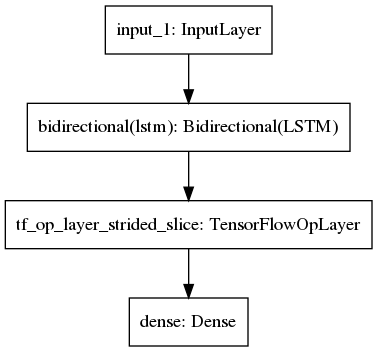

In [31]:
plot_model(model=model,to_file="model.png")

In [ ]:
history = model.fit(batch_gen(X_train,Y_train,time_step,batch_size=32), epochs=100, verbose=2, shuffle=False)

  ...
    to  
  ['...']
Epoch 1/100


In [33]:
i=0
epoch = 0
for (x,y,flag) in batch_gen(X_train,Y_train,time_step,32):
    i=i+1
    #model.fit(x, y, epochs=1, verbose=2, shuffle=False)
    hist = model.train_on_batch(x,y)
    if flag==-1:
        print("1 epoch complete")
        epoch += 1
    if i%1000==0:
        print(hist)
    if epoch>10:
        break

[0.00015876672, 0.0]
[6.764899e-05, 0.0]
[0.0041752085, 0.0]
[0.0004650316, 0.0]
[0.00090793264, 0.0]
[0.00017901025, 0.0]
[0.0009147027, 0.0]
[0.00023036402, 0.0]
[0.0017327694, 0.0]
[0.0004162816, 0.0]
[0.00017140081, 0.0]
[8.1953025e-05, 0.0]
[4.3309286e-05, 0.0]
[2.4400353e-05, 0.0]
[0.0010743291, 0.0]
[7.632084e-05, 0.0]
[3.1023737e-05, 0.0]
[2.170703e-05, 0.0]
[0.0006121274, 0.0]
[0.00016485286, 0.0]
[0.00043740985, 0.0]
[0.0001027494, 0.0]
[5.354589e-05, 0.0]
[0.00114051, 0.0]
[0.00020295558, 0.0]
[0.004567012, 0.0]
[0.00022768989, 0.0]
[0.00010413506, 0.0]
[6.325343e-05, 0.0]
[0.00037948665, 0.0]
[0.000111797155, 0.0]
[5.0793045e-05, 0.0]
[2.2575005e-05, 0.0]
[1.11683585e-05, 0.0]
[5.6326226e-06, 0.0]
[3.0025794e-06, 0.0]
[1.5795217e-06, 0.0]
[8.344647e-07, 0.0]
[3.650784e-07, 0.0]
[2.3841855e-07, 0.0]
[2.3841855e-07, 0.0]
[1.1920928e-07, 0.0]
[1.1920928e-07, 0.0]
[1.1920928e-07, 0.0]
[4.842877e-08, 0.084821425]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.1428

[5.535766e-06, 0.0]
[1.948325e-06, 0.0]
[5.6065464e-06, 0.0]
[1.203268e-06, 0.0]
[4.2095772e-07, 0.0]
[7.405841e-06, 0.0]
[1.5012906e-06, 0.0]
[7.525084e-07, 0.0]
[2.3841855e-07, 0.0]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.00085655786, 0.0]
[3.9420243e-05, 0.0]
[1.6551328e-05, 0.0]
1 epoch complet

[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[0.0, 0.14285715]
[5.98337e-05, 0.0]
[0.00014618461, 0.0]
[5.385135e-05, 0.0]
1 epoch complete


In [20]:
i=0
for (x,y) in batch_gen(X_train,Y_train,time_step,32):
    i=i+1
    #model.fit(x, y, epochs=1, verbose=2, shuffle=False)
    hist = model.test_on_batch(x,y)
    if i%100==0:
        print(hist)
    if i>1000:
        break

[0.00052251795, 0.0]
[0.00054161856, 0.0]
[0.0005698331, 0.0]
[0.00056690664, 0.0]
[0.00055195426, 0.0]
[0.000532597, 0.0]
[0.0005252621, 0.0]
[0.00051768136, 0.0]
[0.000512908, 0.0]
[0.00050886814, 0.0]


In [21]:
file = database_file_names[1]
test_data = pd.read_csv(file)
X_test = test_data.drop(columns=['label', 'time'])
X_test = X_test.values

X_test = scaler.transform(X_test)
Y_test = test_data['label'].values
Y_test = Y_test.reshape((-1,1))

Y_test = encoder.transform(Y_test).toarray()

In [22]:
i=0
for (x,y) in batch_gen(X_test,Y_test,time_step,32):
    i=i+1
    #model.fit(x, y, epochs=1, verbose=2, shuffle=False)
    hist = model.test_on_batch(x,y)
    if i%100==0:
        print(hist)
    if i>1000:
        break

[0.00052305043, 0.0]
[0.0005417488, 0.0]
[0.0005702501, 0.0]
[0.00056492223, 0.0]
[0.000551958, 0.0]
[0.00053247786, 0.0]
[0.00052450254, 0.0]
[0.00051711913, 0.0]
[0.0005124202, 0.0]
[0.00050874153, 0.0]


In [29]:
print(model.predict(x))

[[9.99490976e-01 1.03373386e-04 7.20757380e-05 7.41455588e-05
  9.65132349e-05 1.17065581e-04 4.58077084e-05]
 [9.99490976e-01 1.03377031e-04 7.20808239e-05 7.41506519e-05
  9.65201398e-05 1.17069831e-04 4.58099312e-05]
 [9.99490976e-01 1.03376835e-04 7.20807584e-05 7.41505137e-05
  9.65199506e-05 1.17069714e-04 4.58098439e-05]
 [9.99490976e-01 1.03388869e-04 7.20934040e-05 7.41603362e-05
  9.65330182e-05 1.17083895e-04 4.58140858e-05]
 [9.99490976e-01 1.03388869e-04 7.20934768e-05 7.41602635e-05
  9.65331128e-05 1.17084011e-04 4.58140858e-05]
 [9.99490976e-01 1.03388476e-04 7.20933385e-05 7.41600525e-05
  9.65328363e-05 1.17083895e-04 4.58139111e-05]
 [9.99490857e-01 1.03390332e-04 7.20947792e-05 7.41621698e-05
  9.65380750e-05 1.17080534e-04 4.58108007e-05]
 [9.99490976e-01 1.03383936e-04 7.20876342e-05 7.41558106e-05
  9.65298022e-05 1.17072959e-04 4.58081449e-05]
 [9.99490976e-01 1.03383638e-04 7.20875614e-05 7.41556723e-05
  9.65297149e-05 1.17072836e-04 4.58081013e-05]
 [9.994909

In [30]:
print(y)

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [2]:
x = np.array([[.5,.2,.3],[.1,.6,.3],[.2,.2,.6]]) 

In [5]:
print(np.argmax(x,axis=0))

[0 1 2]


In [17]:
y = np.zeros((3,3))
print(y)
indxs = np.argmax(x,axis=0)
print(indxs)
y[np.arange(3),indxs]=1
print(y)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[0 1 2]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]


array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])